<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Построенная модель должна быть со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install torch

In [2]:
!pip install transformers

In [3]:
!pip install wordcloud

In [4]:
!/opt/conda/bin/python -m pip install wordcloud 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
import catboost
from catboost import CatBoostClassifier
from tqdm import notebook
import torch
import transformers
from transformers import BertTokenizer, BertModel
from wordcloud import WordCloud
import nltk
import re
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import string
from nltk.probability import FreqDist

Импортировал необходимые библиотеки.

In [6]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
# toxic_comments = pd.read_csv('C://Users//smirn//Downloads//Практикум//проекты//Проект NLP//toxic_comments.csv', index_col=[0])
toxic_comments

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


Загрузил датафрейм.

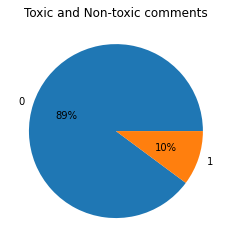

In [7]:
tc = toxic_comments['toxic'].value_counts()
plt.pie(tc, labels=tc.index.values, autopct='%i%%');
plt.title("Toxic and Non-toxic comments");

Построил как распределены комментарии по токсичности.

In [8]:
toxic_comments[toxic_comments['toxic'] == 1]['toxic'].count() / toxic_comments.shape[0]

0.10161213369158527

В исходных данных примерно 10% токсичных комментариев.

In [9]:
toxic_copy = toxic_comments.copy()
toxic_copy = toxic_copy.reset_index(drop=True)
toxic_copy

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
wnl = WordNetLemmatizer() 

def lemm_re_tokenize(text):
    text = text.lower()
    text = text.replace("'", '')
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    text = text.split(' ')
    text = [i for i in text if i]
    text = [wnl.lemmatize(str(word)) for word in text]
    text = ' '.join(text)
    text_tokens = word_tokenize(text)
    return text_tokens

In [12]:
%%time

toxic_copy['text'] = toxic_copy['text'].apply(lemm_re_tokenize)
toxic_copy['text']

CPU times: user 1min 24s, sys: 761 ms, total: 1min 24s
Wall time: 1min 25s


0         [explanation, why, the, edits, made, under, my...
1         [daww, he, match, this, background, colour, im...
2         [hey, man, im, really, not, trying, to, edit, ...
3         [more, i, cant, make, any, real, suggestion, o...
4         [you, sir, are, my, hero, any, chance, you, re...
                                ...                        
159287    [and, for, the, second, time, of, asking, when...
159288    [you, should, be, ashamed, of, yourself, that,...
159289    [spitzer, umm, there, no, actual, article, for...
159290    [and, it, look, like, it, wa, actually, you, w...
159291    [and, i, really, dont, think, you, understand,...
Name: text, Length: 159292, dtype: object

In [13]:
general_list = []
for i in range(len(toxic_copy)):
    general_list += toxic_copy['text'][i]
general_list

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 'they',
 'werent',
 'vandalism',
 'just',
 'closure',
 'on',
 'some',
 'gas',
 'after',
 'i',
 'voted',
 'at',
 'new',
 'york',
 'doll',
 'fac',
 'and',
 'please',
 'dont',
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk',
 'page',
 'since',
 'im',
 'retired',
 'now',
 'daww',
 'he',
 'match',
 'this',
 'background',
 'colour',
 'im',
 'seemingly',
 'stuck',
 'with',
 'thanks',
 'talk',
 'january',
 'utc',
 'hey',
 'man',
 'im',
 'really',
 'not',
 'trying',
 'to',
 'edit',
 'war',
 'it',
 'just',
 'that',
 'this',
 'guy',
 'is',
 'constantly',
 'removing',
 'relevant',
 'information',
 'and',
 'talking',
 'to',
 'me',
 'through',
 'edits',
 'instead',
 'of',
 'my',
 'talk',
 'page',
 'he',
 'seems',
 'to',
 'care',
 'more',
 'about',
 'the',
 'formatting',
 'than',
 'the',
 'actual',
 'info',
 'more',
 'i',
 'cant',
 'make',
 'any',
 'real'

In [14]:
text_raw = " ".join(general_list)

In [15]:
!/opt/conda/bin/python -m pip install wordcloud 

In [16]:
pip install --upgrade Pillow

Note: you may need to restart the kernel to use updated packages.


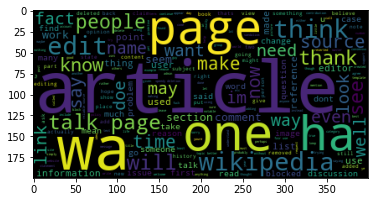

In [17]:
wordcloud = WordCloud().generate(text_raw)
plt.imshow(wordcloud);

In [18]:
toxic_comments = toxic_comments.sample(1600)

Создание всех эмбеддингов заняло бы у меня очень много времени. Поэтому возьму 1600 элементов.

In [19]:
toxic_comments[toxic_comments['toxic'] == 1]['toxic'].count() / toxic_comments.shape[0]

0.105625

Процент токсичных комментариев не сильно поменялся.

In [20]:
toxic_comments = toxic_comments.reset_index(drop=True)
toxic_comments

,text,toxic
0,Good idea. Find a reference and either start ...,0
1,I have not accused Itsmejudith or anyone else ...,0
2,Looks like they have a real annoying javascrip...,0
3,"Marion van de Wetering\n\nFirst, you don't use...",0
4,"""\n Hello, Gallywacks7, and Welcome to Wikiped...",0
...,...,...
1595,Your sources are despicable.\nThey are a bunch...,0
1596,"""\n\nHuh ? If they are English by descent, """"i...",0
1597,Fuck You\n\nGo suck on a fat dick faggot mothe...,1
1598,I removed the content - this is not a soapbox ...,1


Поправил индексацию.

In [21]:
print('Количество пропусков:')
print(toxic_comments.isna().sum())
print()
print('Количество дубликатов:')
print(toxic_comments.duplicated().sum())

Количество пропусков:
text     0
toxic    0
dtype: int64

Количество дубликатов:
0


В данных нет дубликатов и пропусков.

## Обучение

In [22]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Взяли предобученную модель BERT, и его токинезатор.

In [23]:
%%time

MAX_TOKENS = 512

tokenized = toxic_comments['text'].apply(lambda x: tokenizer.encode(x, max_length=MAX_TOKENS,
                                                                    truncation=True, add_special_tokens=True)) 

CPU times: user 475 ms, sys: 3.92 ms, total: 479 ms
Wall time: 479 ms


In [24]:
%%time

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

CPU times: user 64.1 ms, sys: 3.85 ms, total: 67.9 ms
Wall time: 67.1 ms


Текст преобразовали в номера токенов.    
Применили `padding`, чтобы после токенизации длины исходных текстов в корпусе были равными. Это необходимо для работы BERT.
Создали `attention_mask`, чтобы пояснить модели, что нули не несут значимой информации.

In [25]:
padded

array([[ 101, 2204, 2801, ...,    0,    0,    0],
       [ 101, 1045, 2031, ...,    0,    0,    0],
       [ 101, 3504, 2066, ...,    0,    0,    0],
       ...,
       [ 101, 6616, 2017, ...,    0,    0,    0],
       [ 101, 1045, 3718, ...,    0,    0,    0],
       [ 101, 1045, 2123, ...,    0,    0,    0]])

In [26]:
padded.shape

(1600, 512)

In [27]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [28]:
attention_mask.shape

(1600, 512)

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/16 [00:00<?, ?it/s]

BERT создаёт эмбеддинги батчами. Сделали батч небольшим, чтобы хватило оперативной памяти.    
В цикле по батчам данные преобразуем в тензоры.    
Модели передаём данные и `attention_mask`.    
Получили список эмбеддингов.

In [ ]:
features = np.concatenate(embeddings)

Все эмбеддинги собрали в матрицу признаков.

In [ ]:
features.shape

In [ ]:
X_train, X_test_valid, y_train, y_test_valid  = train_test_split(features, toxic_comments['toxic'],
                                                                 stratify=toxic_comments['toxic'],
                                                                 test_size=0.5,
                                                                 random_state=42)

X_test, X_valid, y_test, y_valid  = train_test_split(X_test_valid, y_test_valid,
                                                     stratify=y_test_valid,
                                                     test_size=0.5,
                                                     random_state=42)

Данные делим на train и test.

### LogisticRegression

In [ ]:
log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train, y_train)

Обучил логистическую регрессию.

In [ ]:
f1_score(y_valid, log_reg.predict(X_valid))

Посчитал f1 на валидационной выборке.

### CatBoost

In [ ]:
%%time 

model = CatBoostClassifier(eval_metric='F1', random_seed=42)

grid = {'n_estimators': [100, 1000, 1100],
        'max_depth': [4, 6],
        'learning_rate': [0.0001, 0.03, 0.1]}

grid_search_result = model.grid_search(grid,
                                          X=X_train,
                                          y=y_train,
                                          cv=3,
                                          plot=True)

In [ ]:
grid_search_result["params"]

In [ ]:
%%time
final_cat = CatBoostClassifier(n_estimators=grid_search_result["params"]["iterations"],
                              learning_rate=grid_search_result["params"]['learning_rate'],
                              max_depth=grid_search_result["params"]['depth'],
                              eval_metric='F1',
                              verbose=100,
                              random_seed=42)
final_cat.fit(X_train, y_train)

In [ ]:
print("CatBoost:", f1_score(y_valid, final_cat.predict(X_valid)))

Catboost показал себя лучше.

## Тестирование

In [ ]:
f1_score(y_test, final_cat.predict(X_test))

Catboost показал f1 больше 0.75 на тестовой выборке.

## Выводы

Решили задачу определения токсичности комментариев.    
Подготовили данные и использовали модель BERT.    
С помощью BERT получили эмбеддинги.     
Для решения задачи классификации применили LogisticRegression и CatBoostClassifier.    
В качестве метрики выбрали F1.     
CatBoostClassifier показал лучший результат.     
На тесте получили 0.925